In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from sklearn.metrics import recall_score


In [3]:

def top_k_accuracy_for_label1(y_true, y_prob, k=100):
    """
    Ewaluacja: wybierz k próbek z najwyższym prawdopodobieństwem klasy 1,
    a następnie policz, ile z nich rzeczywiście miało label 1.
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob).flatten()  # zakładamy sigmoid / predict_proba[:,1]

    # Pobieramy indeksy top-k największych wartości
    top_k_idx = np.argsort(y_prob)[-k:][::-1]  # posortowane malejąco

    # Prawdziwe etykiety dla top-k
    y_top_k = y_true[top_k_idx]

    # Accuracy: ile z nich to naprawdę klasa 1
    top_k_acc = np.mean(y_top_k == 1)

    return top_k_acc


In [4]:
def calculate_profit(y_true, y_pred, num_features):
    correct = np.sum((y_pred == 1) & (y_true == 1) | (y_pred == 0) & (y_true == 0))
    profit = correct * 10 - num_features * 200
    return profit

In [5]:
# Wczytanie danych
X = pd.read_table('x_train.txt', sep=" ", header=None)
y = pd.read_table('y_train.txt', header=None).to_numpy(dtype=np.int8).squeeze()

# Skalowanie
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Funkcja do obliczania VIF
def compute_vif(X):
    X_const = sm.add_constant(X)
    vif = pd.Series(
        [variance_inflation_factor(X_const.values, i + 1) for i in range(X.shape[1])],
        index=X.columns
    )
    return vif

# Iteracyjnie usuwamy cechy o VIF >= 10
def reduce_vif(X, threshold=10.0):
    while True:
        vif = compute_vif(X)
        max_vif = vif.max()
        if max_vif < threshold:
            break
        feature_to_drop = vif.idxmax()
        print(f"Usuwam cechę: {feature_to_drop} (VIF={max_vif:.2f})")
        X = X.drop(columns=[feature_to_drop])
    return X

# Usuwanie cech z wysokim VIF
X_filtered = reduce_vif(X_scaled)

print(f"\nPozostało {X_filtered.shape[1]} cech po usunięciu VIF ≥ 10.")


Usuwam cechę: 4 (VIF=359344.30)
Usuwam cechę: 425 (VIF=720709.02)
Usuwam cechę: 117 (VIF=393594.39)
Usuwam cechę: 2 (VIF=1341353.45)
Usuwam cechę: 13 (VIF=913795.91)
Usuwam cechę: 298 (VIF=1018453.99)
Usuwam cechę: 1 (VIF=1260504.34)
Usuwam cechę: 6 (VIF=3550788.79)
Usuwam cechę: 3 (VIF=2723336.56)


/Users/natalia/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Usuwam cechę: 0 (VIF=inf)
Usuwam cechę: 5 (VIF=170.72)
Usuwam cechę: 8 (VIF=96.46)
Usuwam cechę: 7 (VIF=13.44)

Pozostało 487 cech po usunięciu VIF ≥ 10.


In [6]:

def plot_histograms(df):
    n_features = df.shape[1]
    cols_per_segment=100
    segments = (n_features + cols_per_segment - 1) // cols_per_segment  # ceiling division

    for i in range(segments):
        start = i * cols_per_segment
        end = min(start + cols_per_segment, n_features)

        cols = df.columns[start:end]

        n_cols = 20  # number of subplots per row
        n_rows = (len(cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols-1, n_rows-1))
        axes = axes.flatten()

        cmap = plt.cm.get_cmap("Set1", 10)

        for j, col in enumerate(cols):
            axes[j].hist(df[col].dropna(), bins=30, color=cmap(i))
            axes[j].set_xticks([])
            axes[j].set_yticks([])

        for k in range(len(cols), len(axes)):
            axes[k].axis('off')
        plt.suptitle(f'Features {start}-{end}', fontsize=20)
        plt.tight_layout()
        plt.show()

/var/folders/8b/k_jb7bwj4kb0ljl8_xf127yh0000gn/T/ipykernel_8052/1832889189.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", 10)


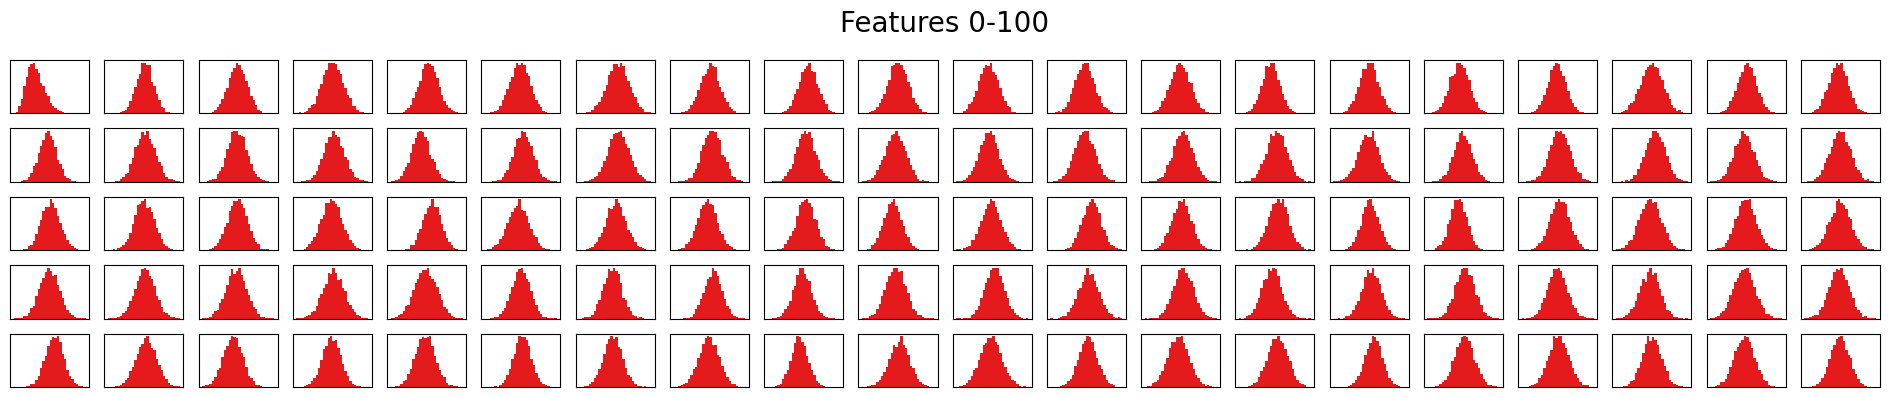

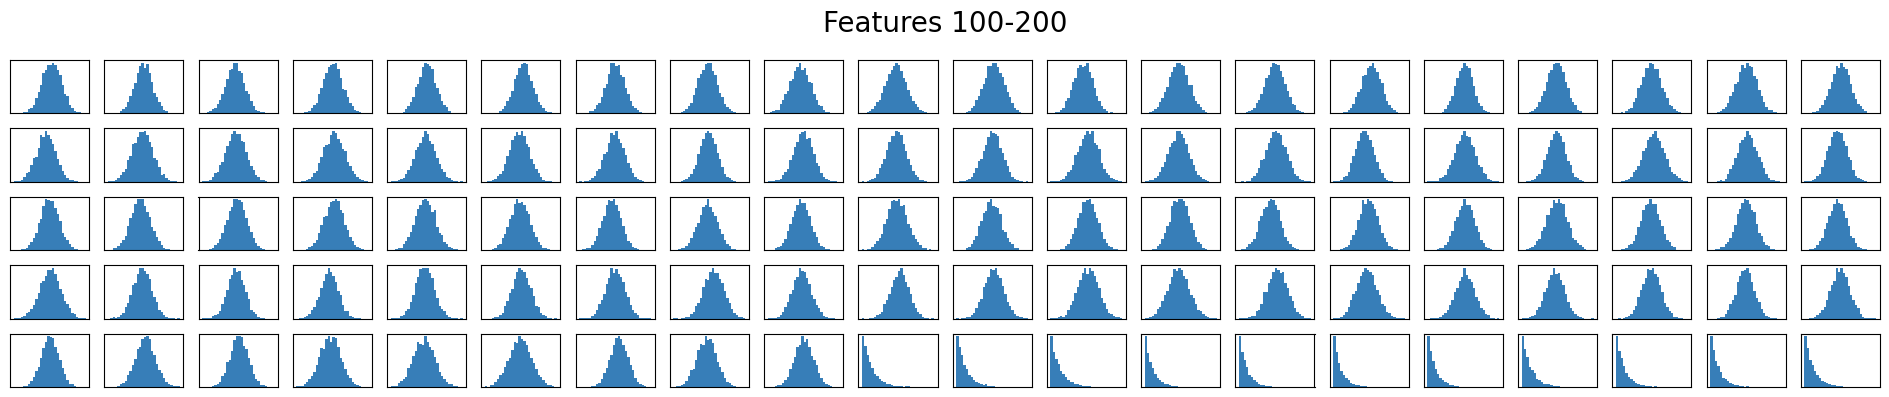

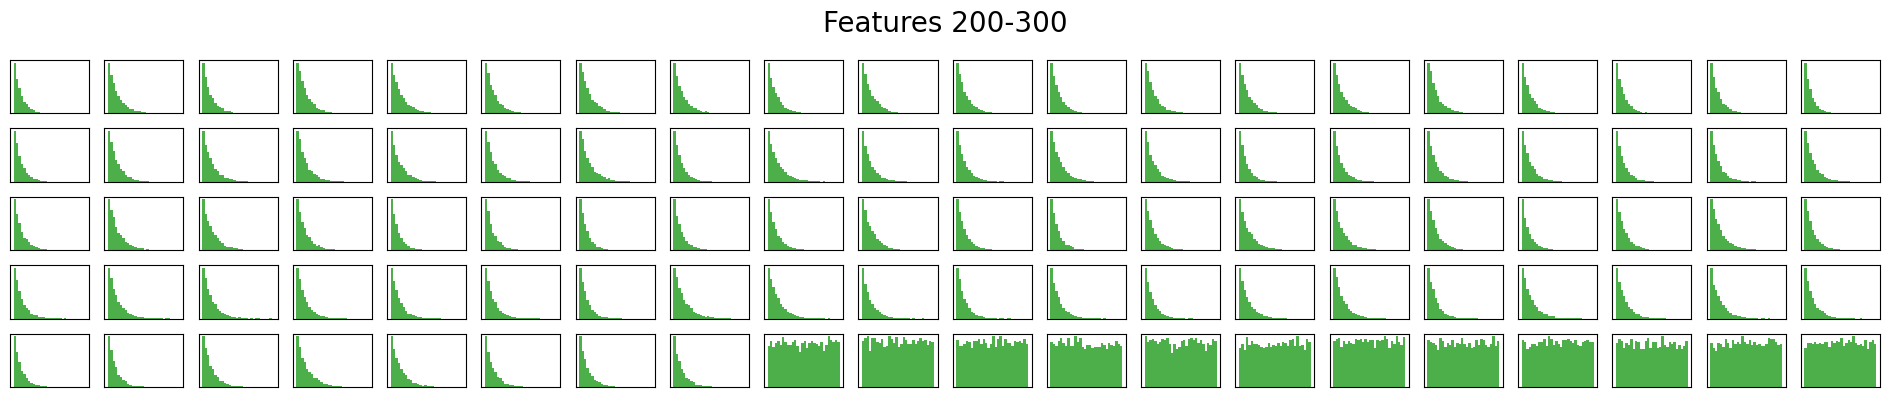

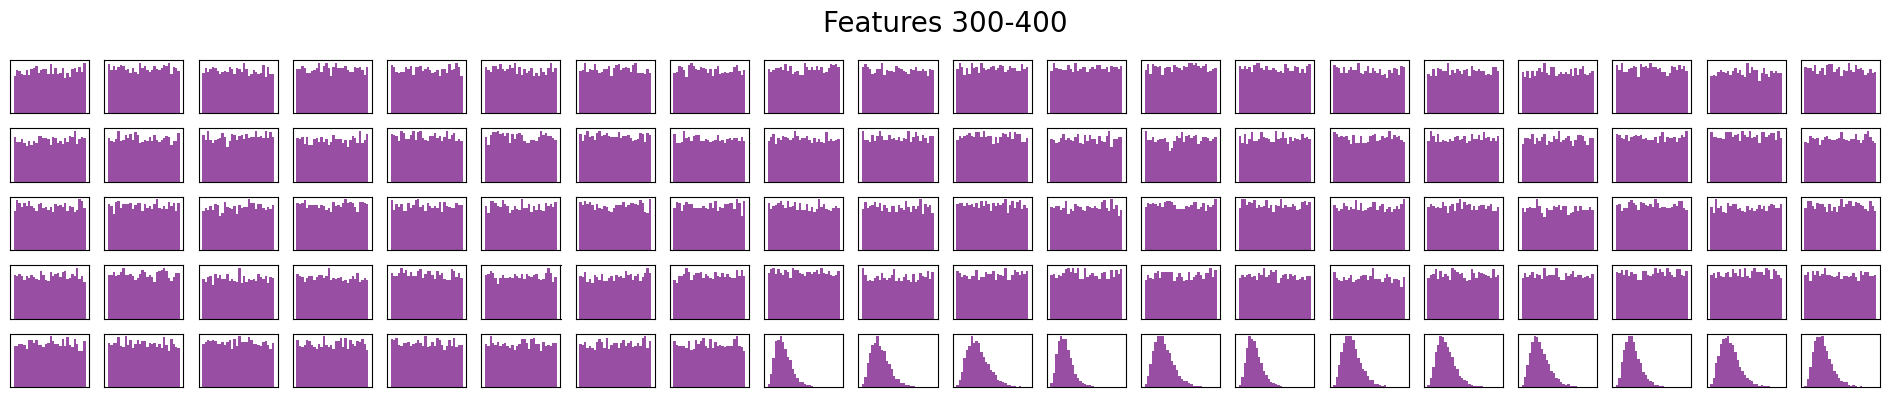

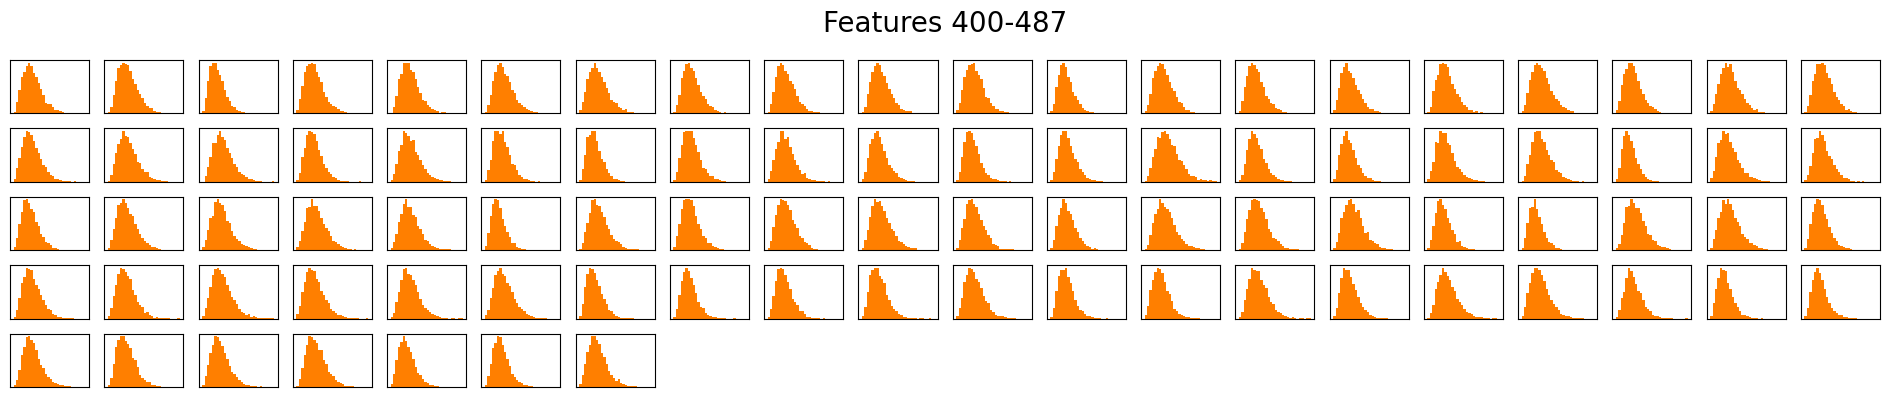

In [7]:
plot_histograms(X_filtered)

In [8]:
normal_cols = list(range(0, 189))
exponential_cols = list(range(189, 288))
uniform_cols = list(range(288, 388))
skewed_normal_cols = list(range(400, 487))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y,
                                                    test_size=200)
normal_cols = list(range(0, 189))
exponential_cols = list(range(189, 288))
uniform_cols = list(range(288, 388))
skewed_normal_cols = list(range(400, 487))

# ==================== only standard scaler approach ====================
naive_scaler = StandardScaler()
X_train_naive_scaled = naive_scaler.fit_transform(X_train)
X_test_naive_scaled = naive_scaler.transform(X_val)

# ==================== unique transformation for each distribution ====================
column_transformer = ColumnTransformer([
    ('standard', StandardScaler(), normal_cols),
    ('quantile', QuantileTransformer(output_distribution='normal', n_quantiles=200), exponential_cols), # 200-300
    ('minmax', MinMaxScaler(), uniform_cols), 
    ('power', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), skewed_normal_cols) 
], remainder='passthrough')

X_train_adaptive_scaled = column_transformer.fit_transform(X_train)
X_val_adaptive_scaled = column_transformer.transform(X_val)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np

# L1 Logistic Regression (Lasso) for feature selection
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
selector = SelectFromModel(model_l1, prefit=False, threshold='mean')  

# Fit selector
selector.fit(X_train_adaptive_scaled, y_train)

# Transform data
X_train_l1 = selector.transform(X_train_adaptive_scaled)
X_val_l1 = selector.transform(X_val_adaptive_scaled)
selected_features_l1 = selector.get_support(indices=True)

# Train final model on selected features
model_l1_final = LogisticRegression(penalty='l2', solver='liblinear')
model_l1_final.fit(X_train_l1, y_train)

# Predict on validation set
y_pred_l1 = model_l1_final.predict(X_val_l1)
profit_l1 = calculate_profit(y_val, y_pred_l1, len(selected_features_l1))

# Output results
print(f"L1 Logistic Regression - Profit: €{profit_l1}, Features: {len(selected_features_l1)}")
print(f"correctly classified: {np.sum((y_pred_l1 == y_val)/len(y_val))}")
print(f"top_k_accuracy: {top_k_accuracy_for_label1(y_val, model_l1_final.predict_proba(X_val_l1)[:, 1], k=100)}")


L1 Logistic Regression - Profit: €380, Features: 5
correctly classified: 0.69
top_k_accuracy: 0.71


In [11]:
selected_features_l1

array([  0, 217, 390, 433, 437])

In [12]:
model_rf = RandomForestClassifier(n_estimators=200)
rfe = RFE(model_rf, n_features_to_select=5)  
rfe.fit(X_train_adaptive_scaled, y_train)

selected_features_rfe = np.where(rfe.support_)[0]
X_train_rfe = X_train_adaptive_scaled[:, selected_features_rfe]
X_val_rfe = X_val_adaptive_scaled[:, selected_features_rfe]

# Train final model
model_rf_final = RandomForestClassifier()
model_rf_final.fit(X_train_rfe, y_train)

# Predict
y_pred_rf = model_rf_final.predict(X_val_rfe)
profit_rf = calculate_profit(y_val, y_pred_rf, len(selected_features_rfe))
print(f"Random Forest + RFE - Profit: €{profit_rf}, Features: {len(selected_features_rfe)}")
print(f"correctly classified: {np.sum((y_pred_l1 == y_val)/len(y_val))}")
print(f"top_k_accuracy: {top_k_accuracy_for_label1(y_val, model_rf_final.predict_proba(X_val_rfe)[:, 1], k=100)}")
print(f"profit: {profit_rf}")

Random Forest + RFE - Profit: €490, Features: 5
correctly classified: 0.69
top_k_accuracy: 0.76
profit: 490


In [13]:
selected_features_rfe

array([  0, 217, 390, 401, 437])

In [14]:
# XGBoost + Feature Importance
model_xgb = XGBClassifier()
model_xgb.fit(X_train_adaptive_scaled, y_train)

# Select top 20 features by importance
importance = model_xgb.feature_importances_
selected_features_xgb = np.argsort(importance)[-5:]
X_train_xgb = X_train_adaptive_scaled[:, selected_features_xgb]
X_val_xgb = X_val_adaptive_scaled[:, selected_features_xgb]

# Train final model
model_xgb_final = XGBClassifier()
model_xgb_final.fit(X_train_xgb, y_train)

# Predict
y_pred_xgb = model_xgb_final.predict(X_val_xgb)
profit_xgb = calculate_profit(y_val, y_pred_xgb, len(selected_features_xgb))
print(f"correctly classified: {np.sum((y_pred_l1 == y_val)/len(y_val))}")
print(f"top_k_accuracy: {top_k_accuracy_for_label1(y_val, model_xgb_final.predict_proba(X_val_xgb)[:, 1], k=100)}")
print(f"XGBoost + Feature Importance - Profit: €{profit_xgb}, Features: {len(selected_features_xgb)}")

correctly classified: 0.69
top_k_accuracy: 0.71
XGBoost + Feature Importance - Profit: €400, Features: 5


In [15]:
selected_features_xgb

array([247, 372, 390, 437,   0])